<a href="https://colab.research.google.com/github/kerimux/FinTech_Project_2/blob/main/us_domestic_migration_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
## Install and import the required libraries and dependencies
# Install the required libraries
!pip install pystan
!pip install prophet
!pip install hvplot
!pip install holoviews

import numpy as np
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.9 MB/s eta 0:00:00


In [88]:
# Import the required libraries and dependencies
import pandas as pd
import holoviews as hv
from prophet import Prophet
import hvplot.pandas
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [3]:
# Upload the "google_hourly_search_trends.csv" file into Colab, then store in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

from google.colab import files
uploaded = files.upload()

Saving state_to_state.csv to state_to_state.csv


In [45]:
migration = pd.read_csv('state_to_state.csv', infer_datetime_format=True, parse_dates=True)


# Review the first and last five rows of the DataFrame
migration

,IBRC_Geo_ID,State,District Name,Year,Births,Deaths,Net International Migration,Net Domestic Migration,Residual
0,6500001,AK,Kenai Peninsula Economic Development District,1990,195,55,3.0,155,0
1,6500001,AK,Kenai Peninsula Economic Development District,1991,766,146,18.0,800,-9
2,6500001,AK,Kenai Peninsula Economic Development District,1992,736,151,43.0,129,-15
3,6500001,AK,Kenai Peninsula Economic Development District,1993,703,194,42.0,70,-12
4,6500001,AK,Kenai Peninsula Economic Development District,1994,693,192,26.0,778,-24
...,...,...,...,...,...,...,...,...,...
12842,6500418,MT,Mission West Community Development Partners,2016,493,520,9.0,367,0
12843,6500418,MT,Mission West Community Development Partners,2017,528,535,29.0,872,2
12844,6500418,MT,Mission West Community Development Partners,2018,462,512,11.0,227,-3
12845,6500418,MT,Mission West Community Development Partners,2019,428,489,27.0,589,-5


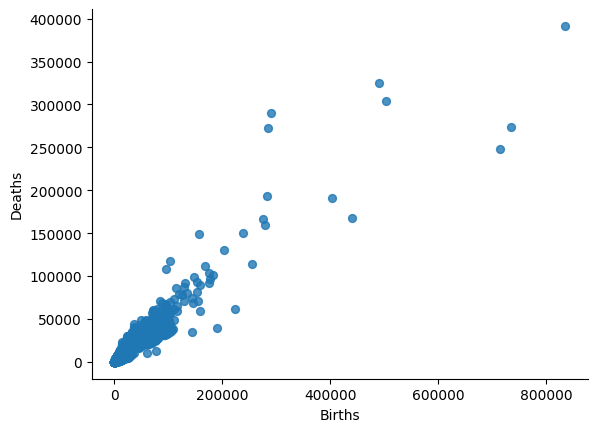

In [95]:
# @title Births vs Deaths

from matplotlib import pyplot as plt
migration.plot(kind='scatter', x='Births', y='Deaths', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [46]:
# Grouping by the 'State' column
grouped_by_state = migration.groupby('State')

# Now, you can perform operations on each group, for example, calculating the mean
by_state = grouped_by_state.sum()

slice_year = migration[(migration['Year'] >= 1990) & (migration['Year'] <= 2020)]

grouped_df = slice_year.groupby(['State', 'Year']).sum()
grouped_df = grouped_df.reset_index()
ca_df = grouped_df[grouped_df['State'] == 'CA'][['Year', 'Net Domestic Migration']]
tx_df = grouped_df[grouped_df['State'] == 'TX'][['Year', 'Net Domestic Migration']]
fl_df = grouped_df[grouped_df['State'] == 'FL'][['Year', 'Net Domestic Migration']]
co_df = grouped_df[grouped_df['State'] == 'CO'][['Year', 'Net Domestic Migration']]
ny_df = grouped_df[grouped_df['State'] == 'NY'][['Year', 'Net Domestic Migration']]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsla2h0bh/md0v0hoa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsla2h0bh/i9per21p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66503', 'data', 'file=/tmp/tmpsla2h0bh/md0v0hoa.json', 'init=/tmp/tmpsla2h0bh/i9per21p.json', 'output', 'file=/tmp/tmpsla2h0bh/prophet_modelk78_xknr/prophet_model-20240222032700.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:27:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:27:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:

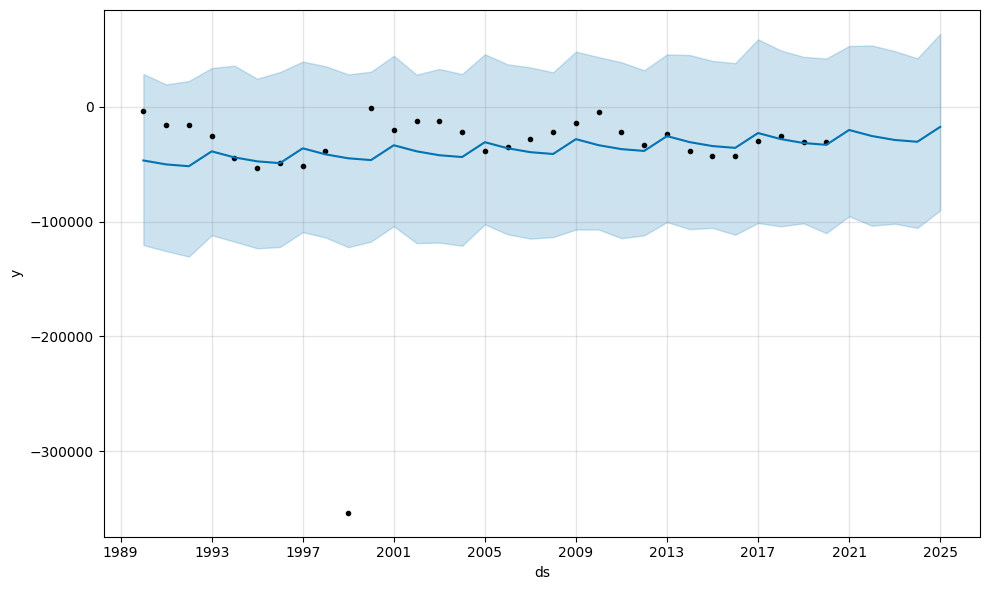

In [9]:
ny_df['ds'] = pd.to_datetime(ny_df['Year'], format='%Y')
ny_df = ny_df[['ds', 'Net Domestic Migration']]
ny_df.rename(columns={'Net Domestic Migration': 'y'}, inplace=True)
# Create the model
ny_model = Prophet()

# Fit the model
ny_model.fit(ny_df)

ny_future = ny_model.make_future_dataframe(periods=5, freq='YS')
# Make predictions
ny_forecast = ny_model.predict(ny_future)

ny_model.plot(ny_forecast);

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsla2h0bh/9y7z3s8v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsla2h0bh/3kv8q7u3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64104', 'data', 'file=/tmp/tmpsla2h0bh/9y7z3s8v.json', 'init=/tmp/tmpsla2h0bh/3kv8q7u3.json', 'output', 'file=/tmp/tmpsla2h0bh/prophet_model1fshzlnk/prophet_model-20240222032702.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:27:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:27:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:

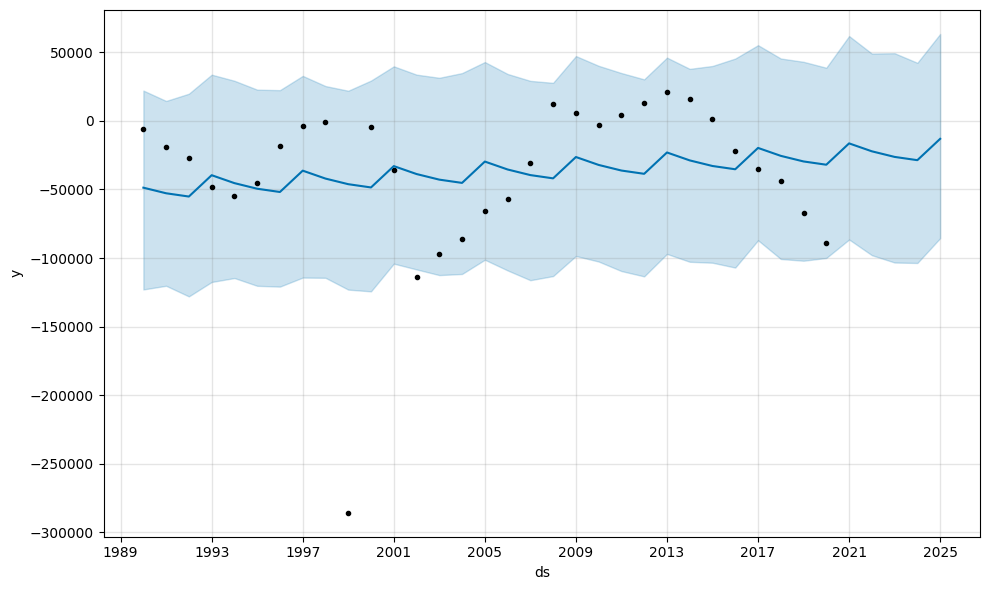

In [10]:
ca_df['ds'] = pd.to_datetime(ca_df['Year'], format='%Y')
ca_df = ca_df[['ds', 'Net Domestic Migration']]

# Rename the 'Net Domestic Migration' column to 'y'
ca_df.rename(columns={'Net Domestic Migration': 'y'}, inplace=True)
# Create the model
ca_model = Prophet()

# Fit the model
ca_model.fit(ca_df)

ca_future = ca_model.make_future_dataframe(periods=5, freq='YS')
# Make predictions
ca_forecast = ca_model.predict(ca_future)

ca_model.plot(ca_forecast);

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsla2h0bh/32w9dmo0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsla2h0bh/w_xndyfk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31433', 'data', 'file=/tmp/tmpsla2h0bh/32w9dmo0.json', 'init=/tmp/tmpsla2h0bh/w_xndyfk.json', 'output', 'file=/tmp/tmpsla2h0bh/prophet_modela06p8pm5/prophet_model-20240222032703.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:27:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:27:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:

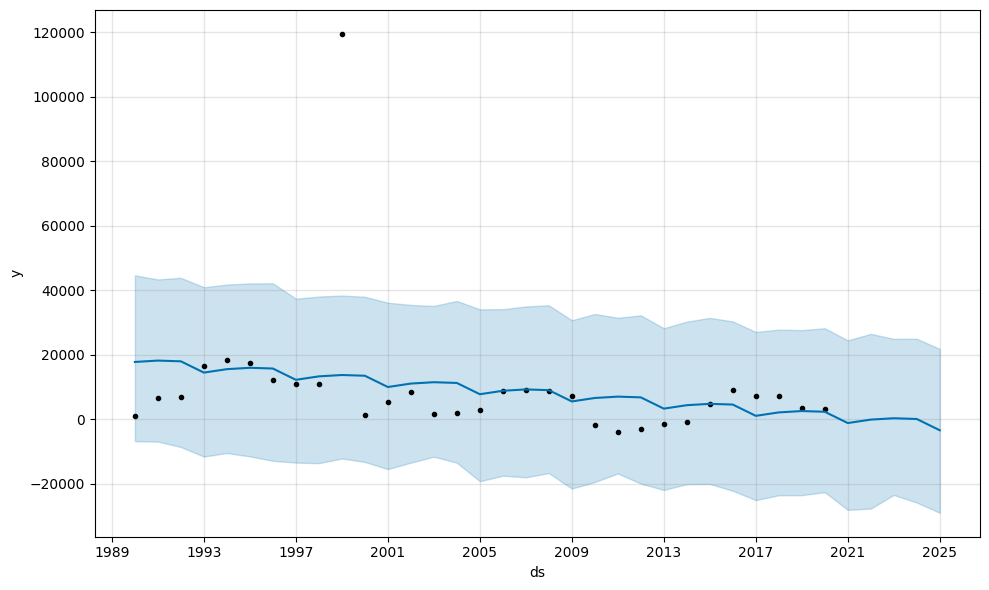

In [11]:
co_df['ds'] = pd.to_datetime(co_df['Year'], format='%Y')
co_df = co_df[['ds', 'Net Domestic Migration']]

# Rename the 'Net Domestic Migration' column to 'y'
co_df.rename(columns={'Net Domestic Migration': 'y'}, inplace=True)
# Create the model
co_model = Prophet()

# Fit the model
co_model.fit(co_df)

co_future = co_model.make_future_dataframe(periods=5, freq='YS')
# Make predictions
co_forecast = co_model.predict(co_future)

co_model.plot(co_forecast);

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsla2h0bh/3kqlcpja.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsla2h0bh/xogh03hy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69044', 'data', 'file=/tmp/tmpsla2h0bh/3kqlcpja.json', 'init=/tmp/tmpsla2h0bh/xogh03hy.json', 'output', 'file=/tmp/tmpsla2h0bh/prophet_modeliij1_fde/prophet_model-20240222043334.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:33:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:33:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:

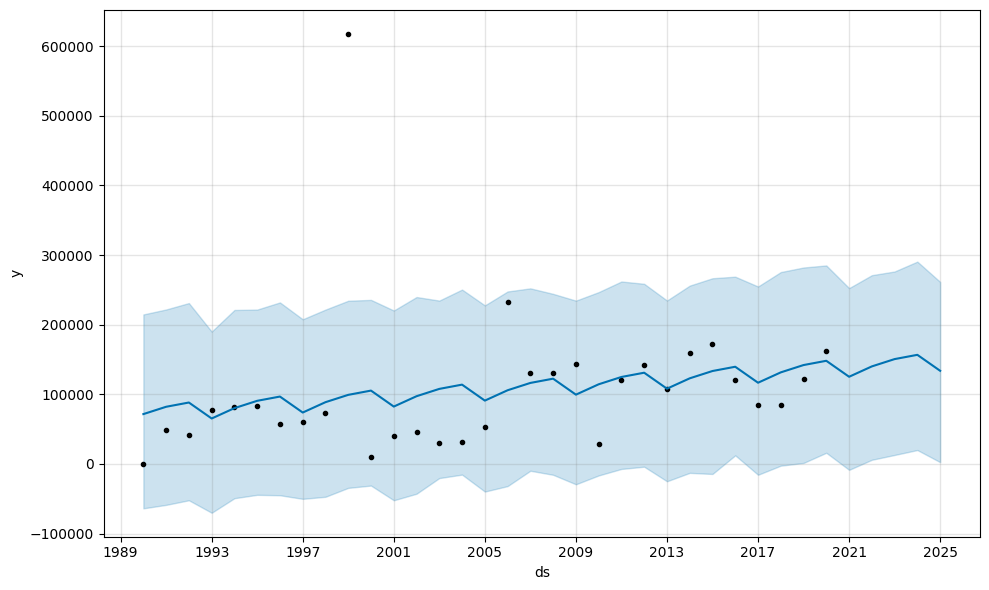

In [74]:
tx_df['ds'] = pd.to_datetime(tx_df['Year'], format='%Y')
tx_df = tx_df[['ds', 'Net Domestic Migration']]

# Rename the 'Net Domestic Migration' column to 'y'
tx_df.rename(columns={'Net Domestic Migration': 'y'}, inplace=True)
# Create the model
tx_model = Prophet()

# Fit the model
tx_model.fit(tx_df)

tx_future = tx_model.make_future_dataframe(periods=5, freq='YS')
# Make predictions
tx_forecast = tx_model.predict(tx_future)

tx_model.plot(tx_forecast);

In [96]:
grouped_by_state = migration.groupby('State')

grouped_df = grouped_by_state.sum()

# Slice the DataFrame based on the specified year range
slice_year = migration[(migration['Year'] >= 2000) & (migration['Year'] <= 2020)]

# Group DataFrame by 'State' and 'Year' and summing the values
grouped_df = slice_year.groupby(['State', 'Year']).sum()

# Reset the index
grouped_df = grouped_df.reset_index()

# Creating individual DataFrames for each state based
state_dfs = {}
for state in grouped_df['State'].unique():
    state_df = grouped_df[grouped_df['State'] == state][['Year', 'Net Domestic Migration']]
    state_dfs[state] = state_df

for state, state_df in state_dfs.items():
    locals()[f"{state}_df"] = state_df

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsla2h0bh/0e6oqdb8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsla2h0bh/1a2mw5wy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64435', 'data', 'file=/tmp/tmpsla2h0bh/0e6oqdb8.json', 'init=/tmp/tmpsla2h0bh/1a2mw5wy.json', 'output', 'file=/tmp/tmpsla2h0bh/prophet_modelis8gr1ms/prophet_model-20240222045356.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:53:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:53:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:

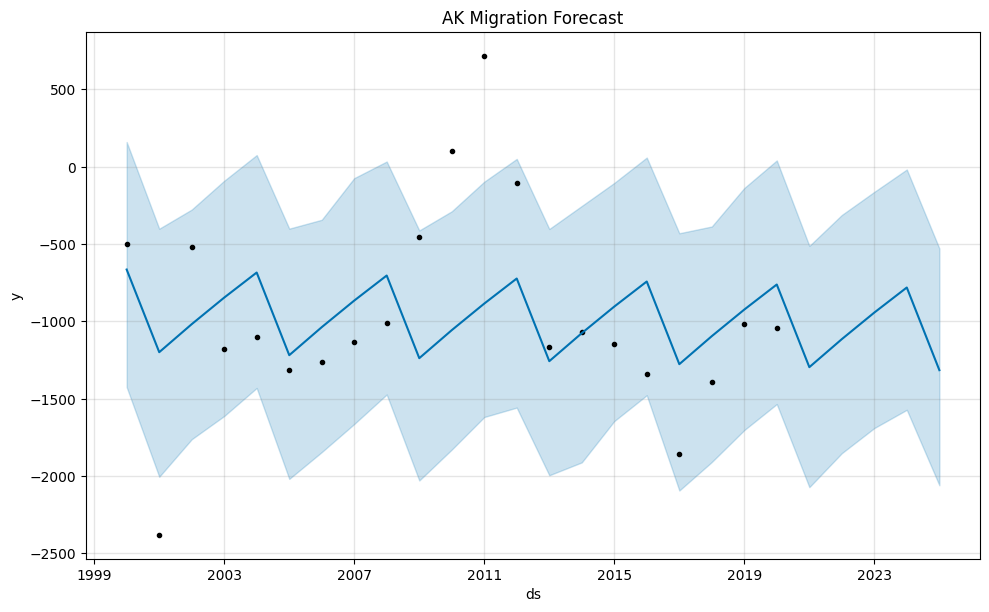

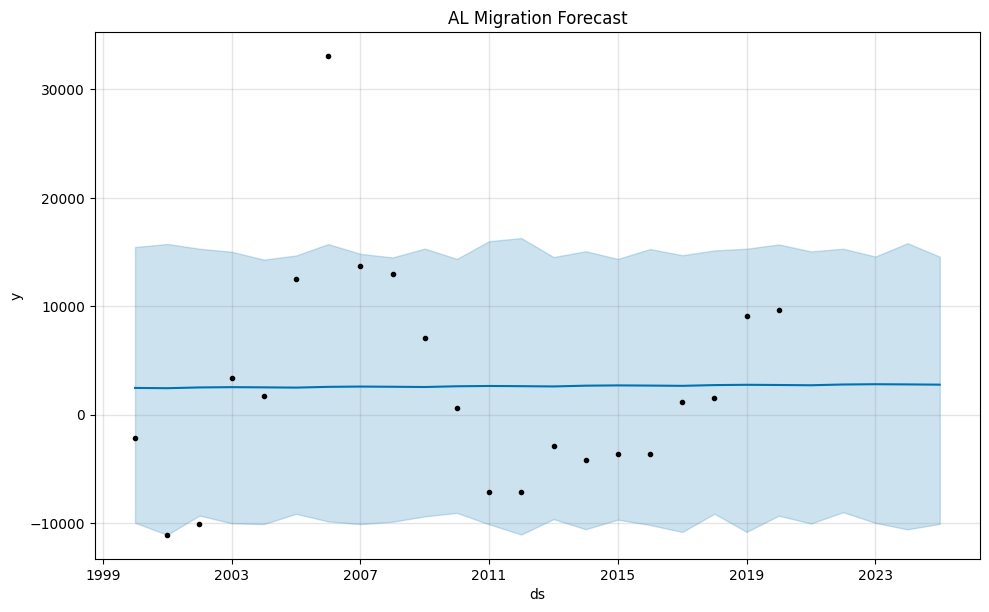

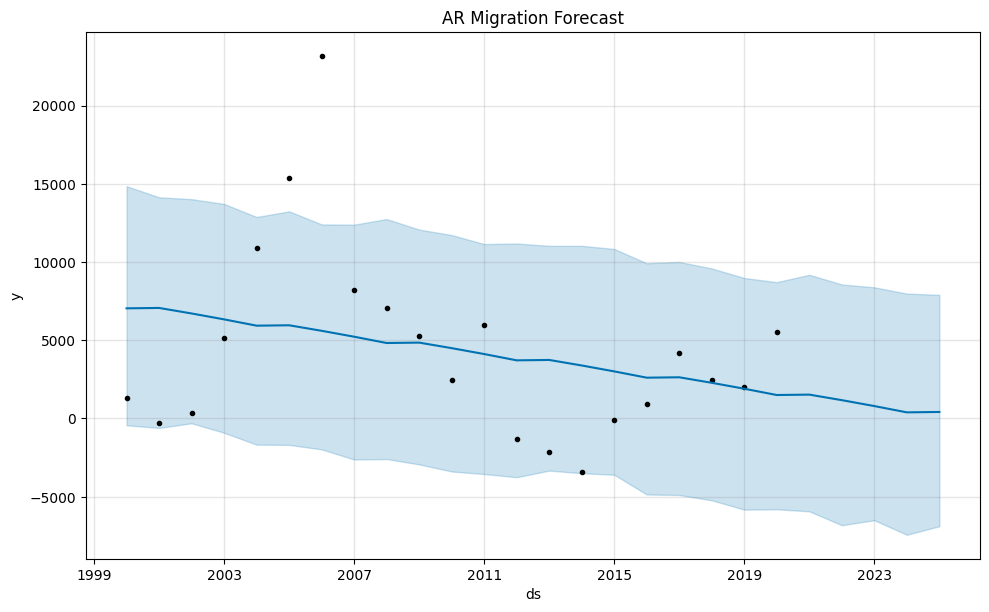

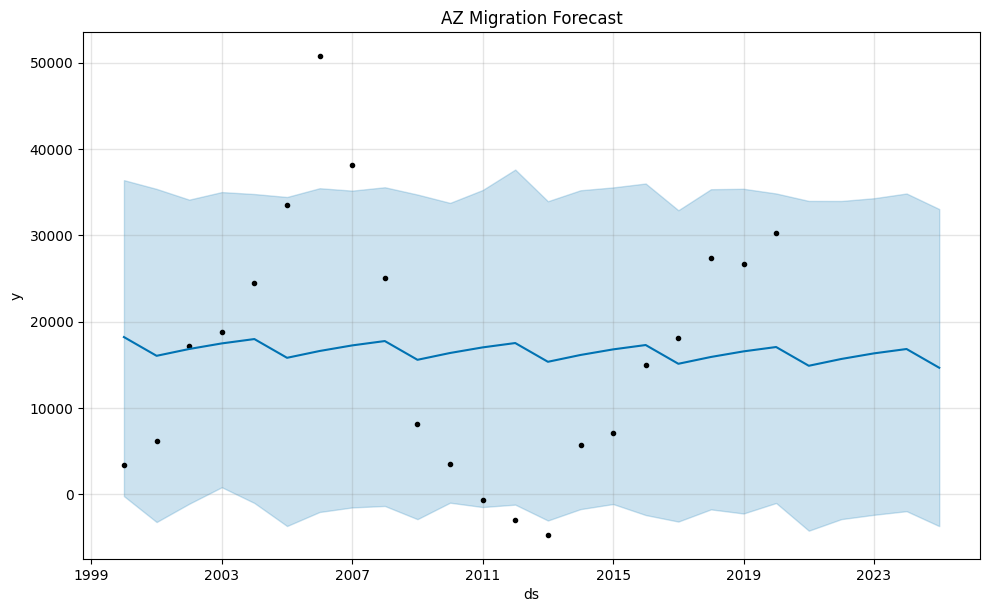

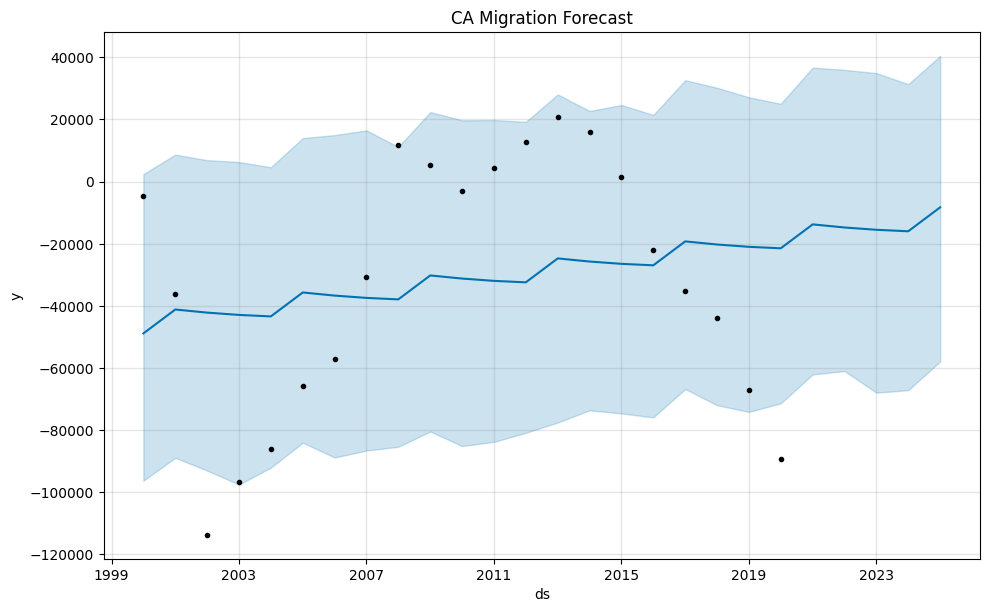

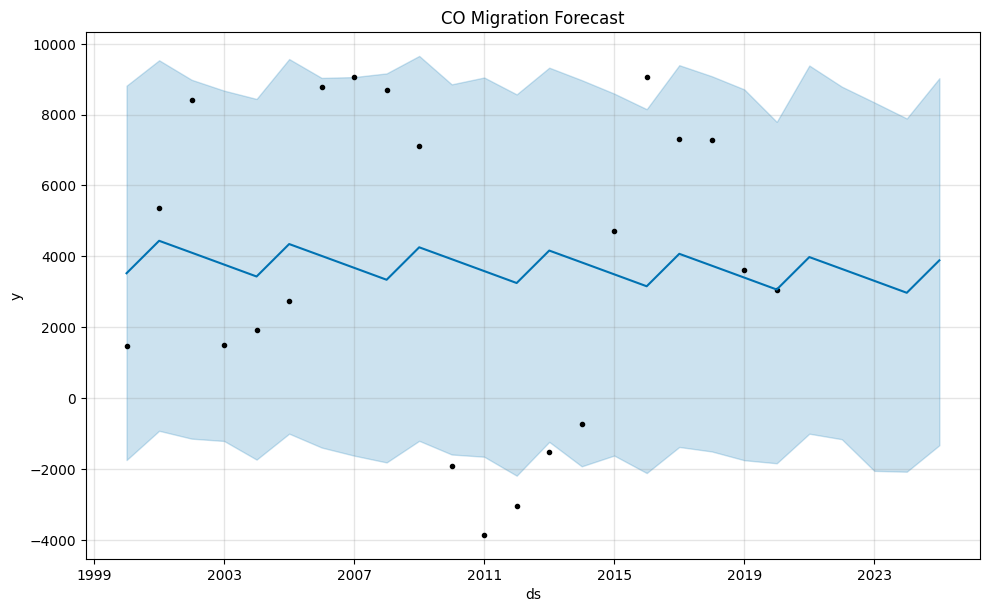

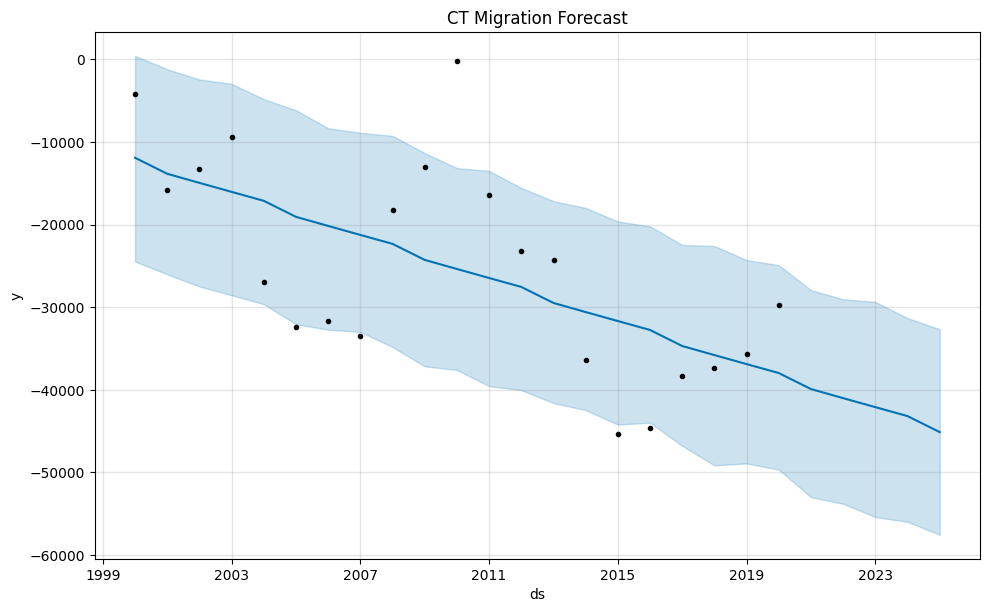

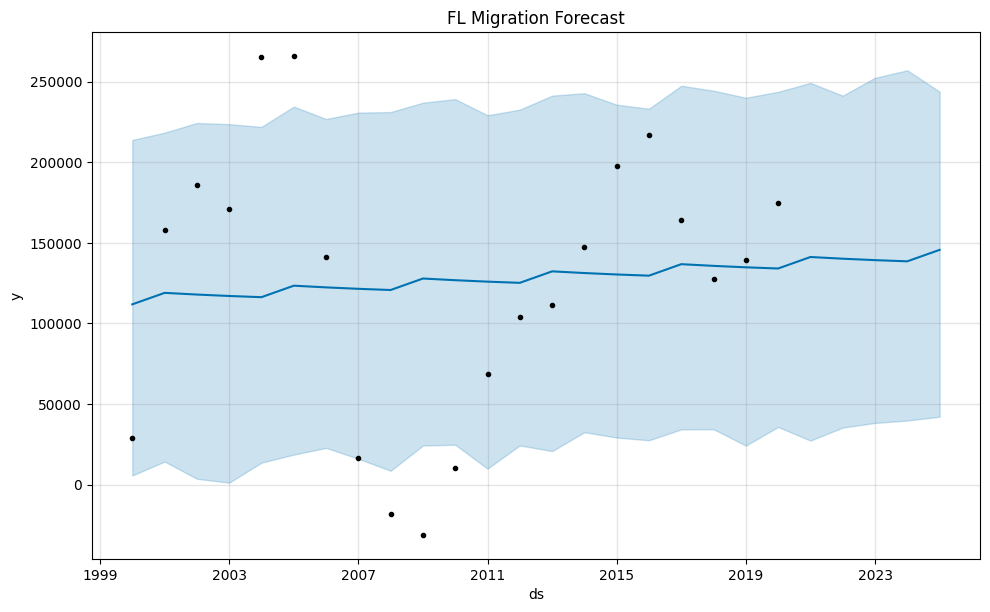

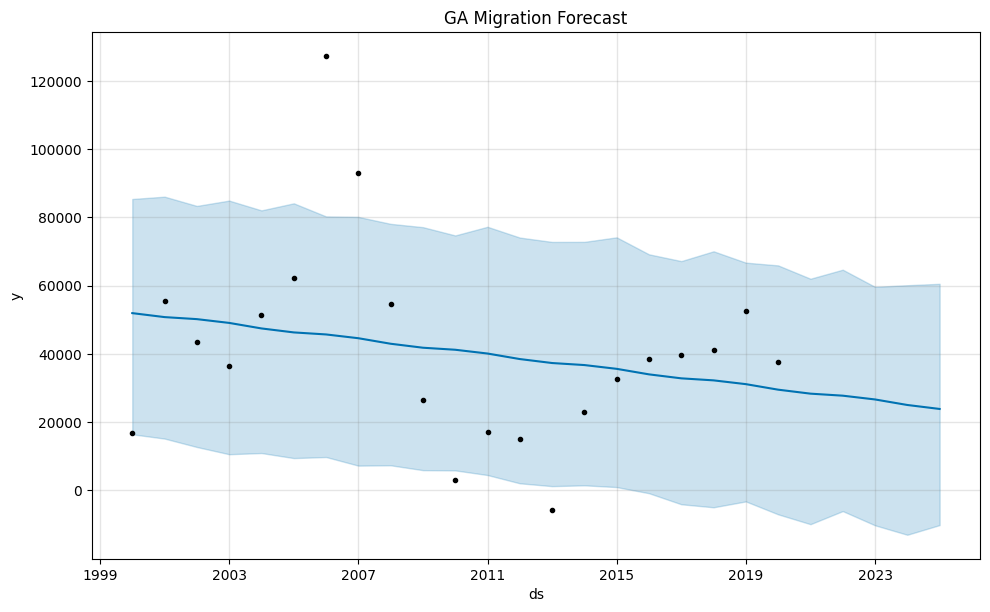

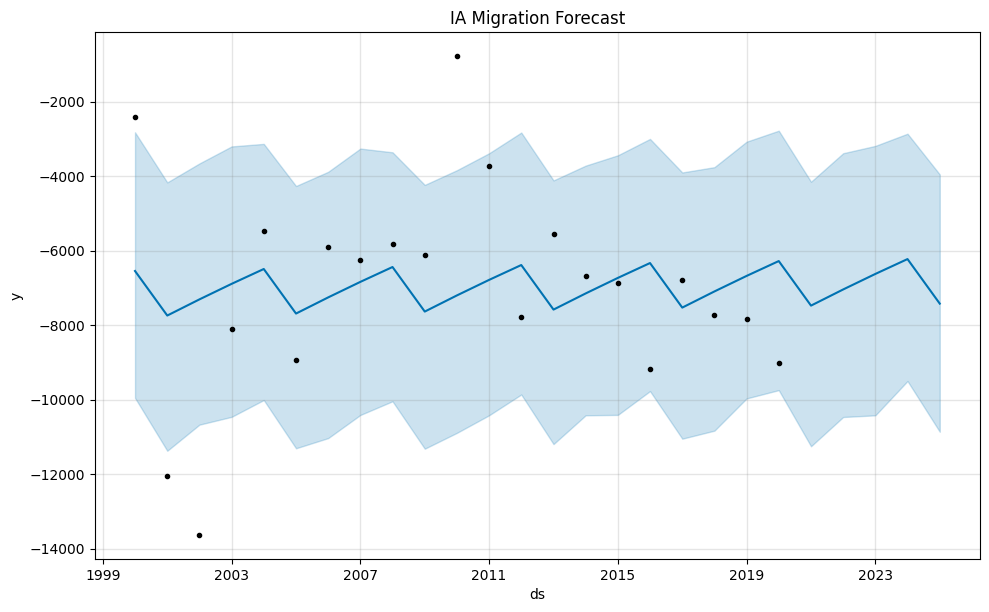

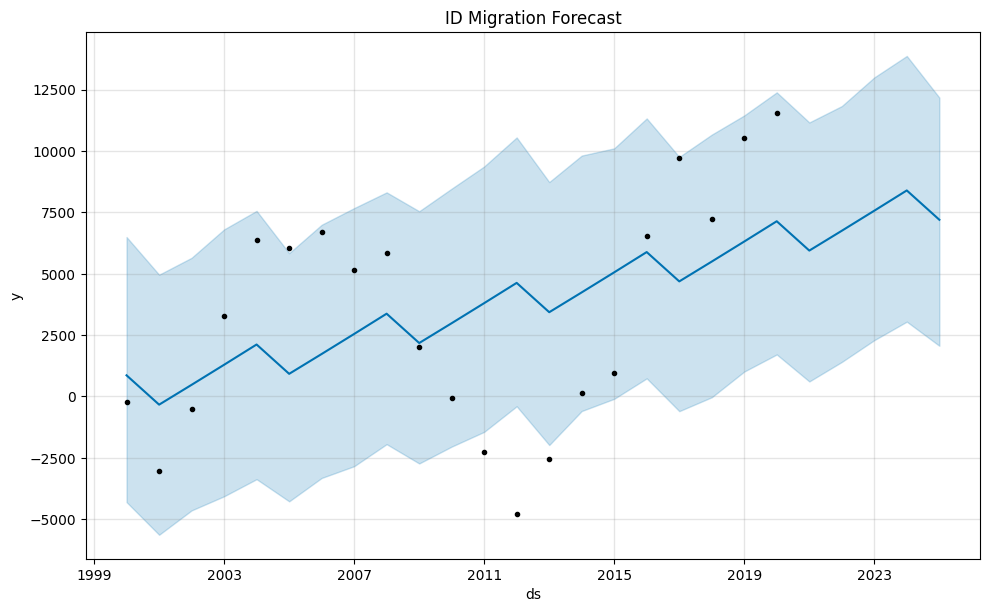

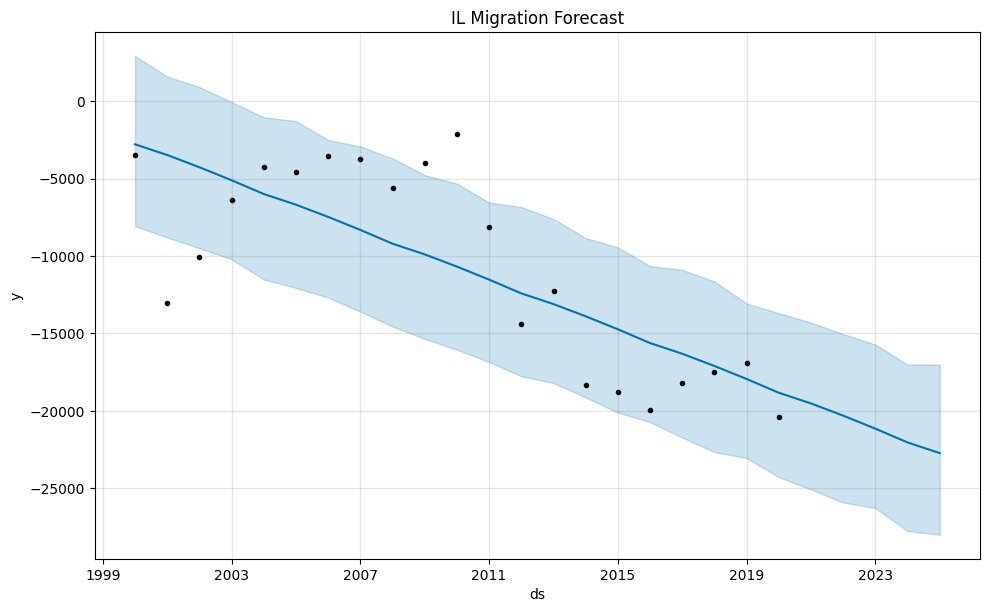

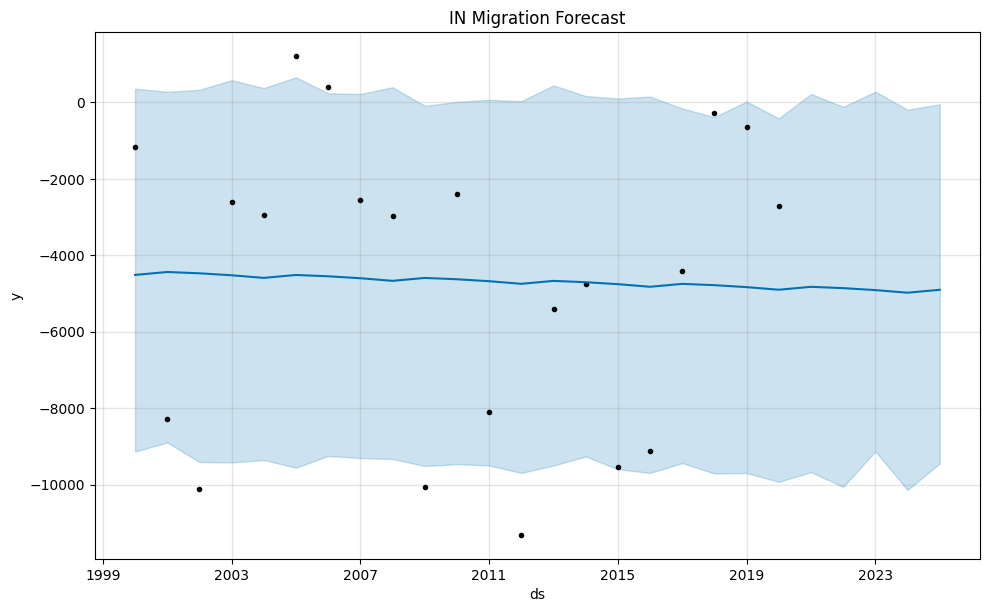

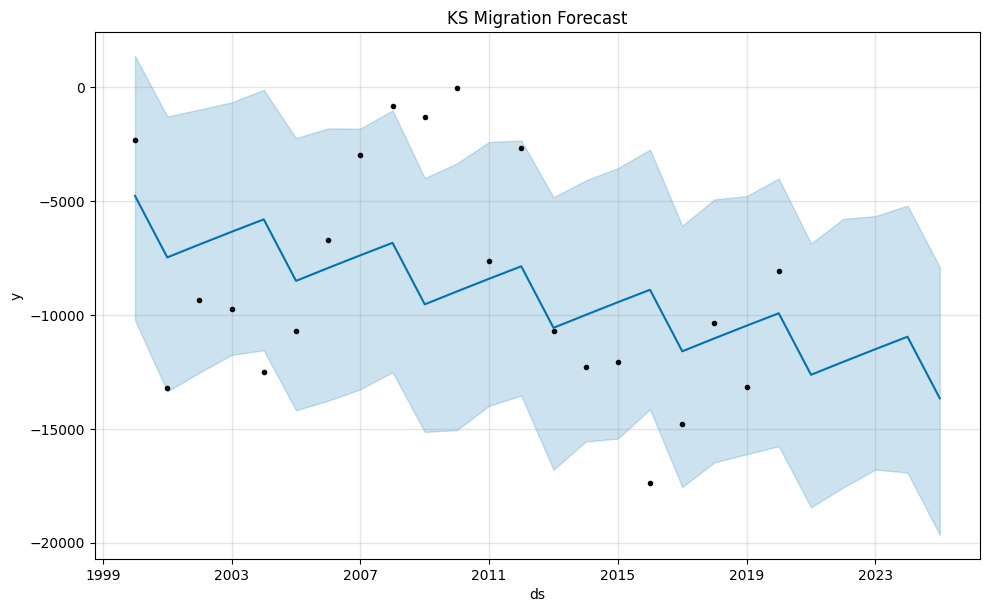

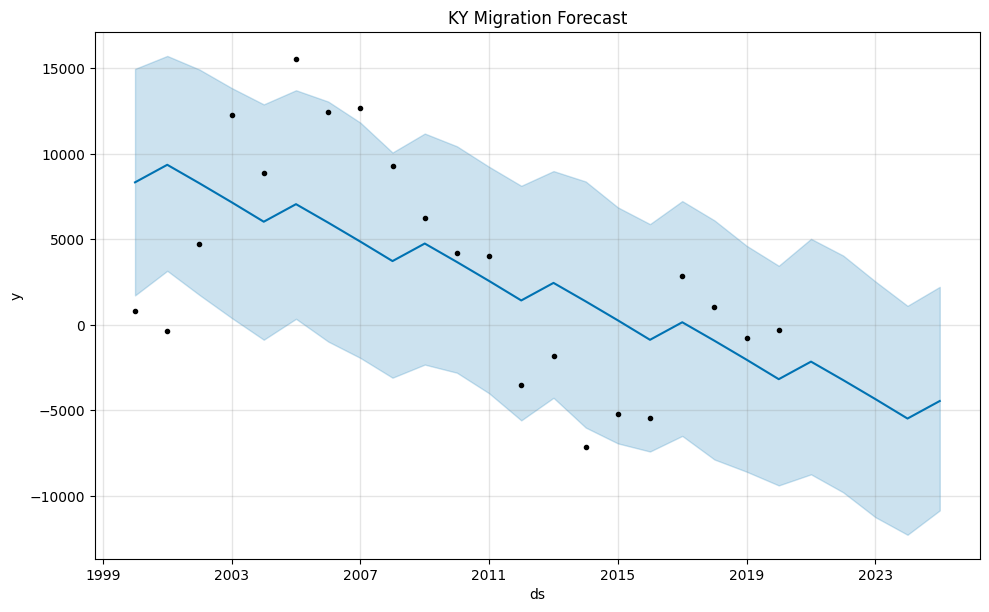

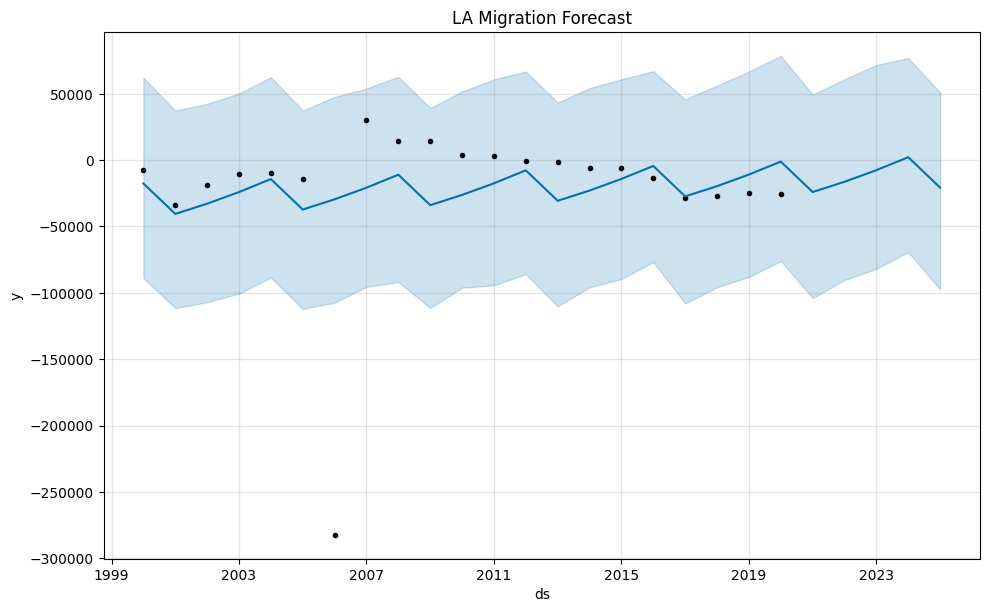

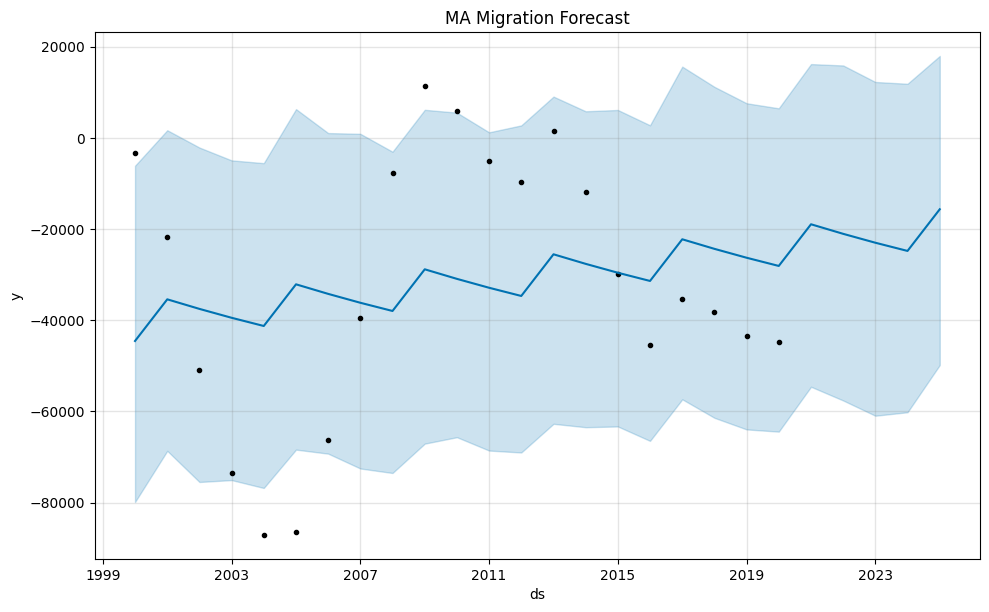

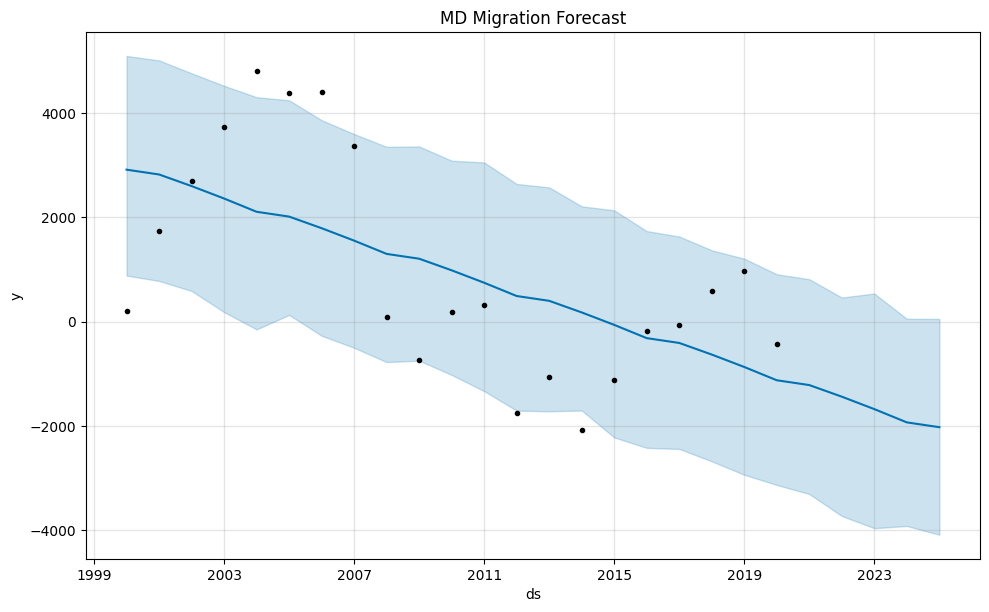

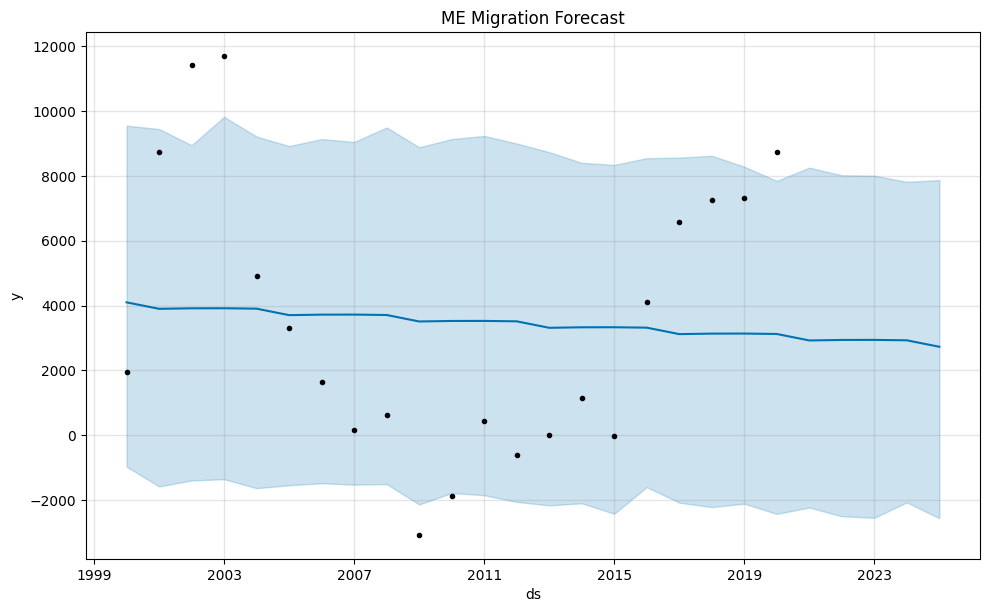

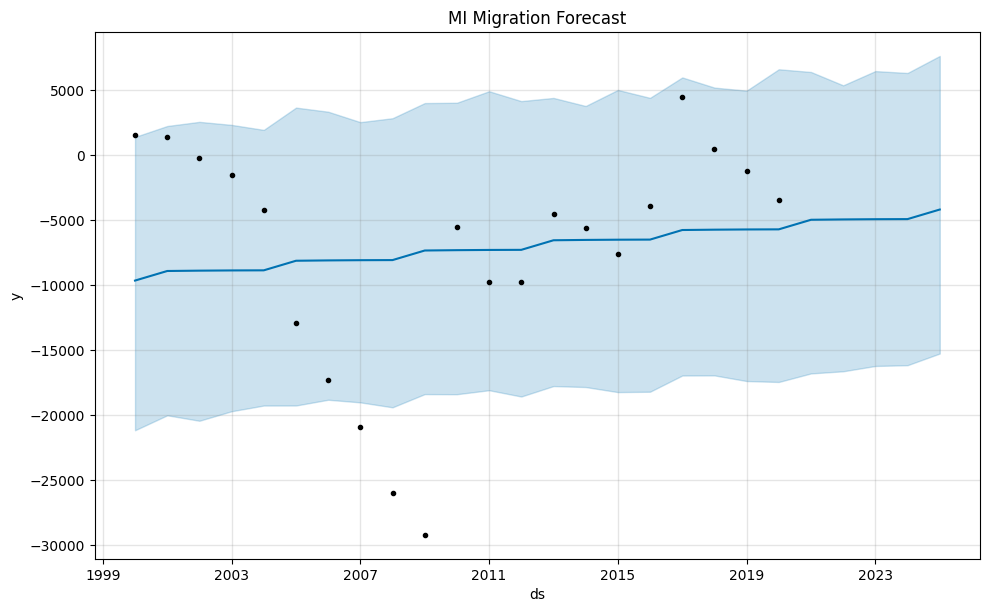

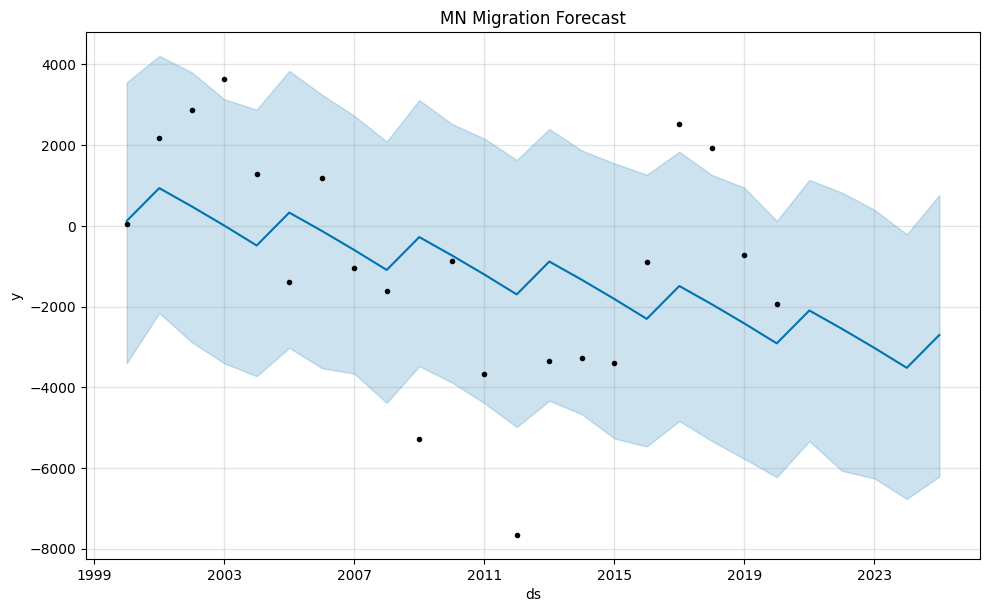

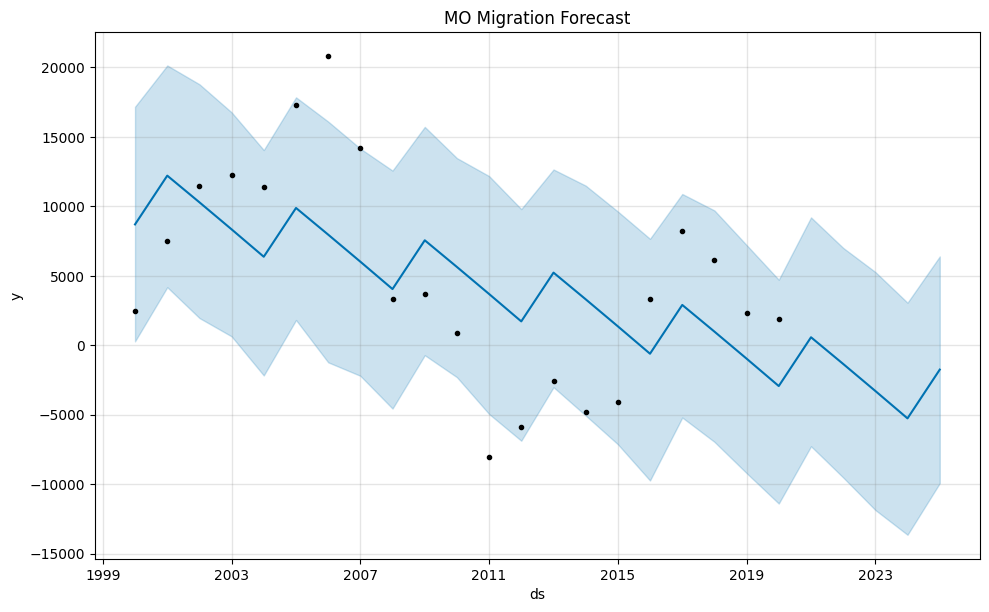

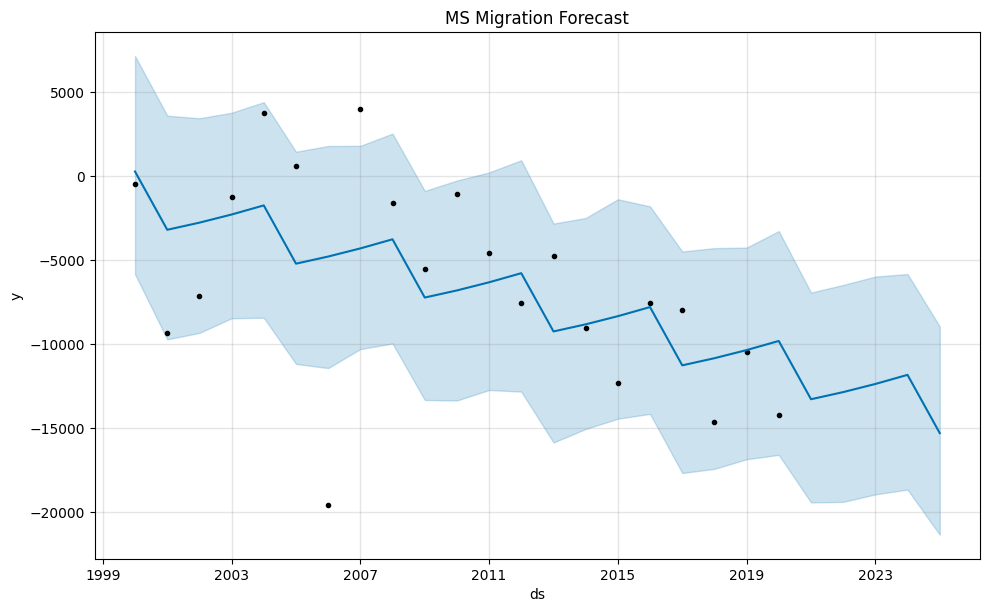

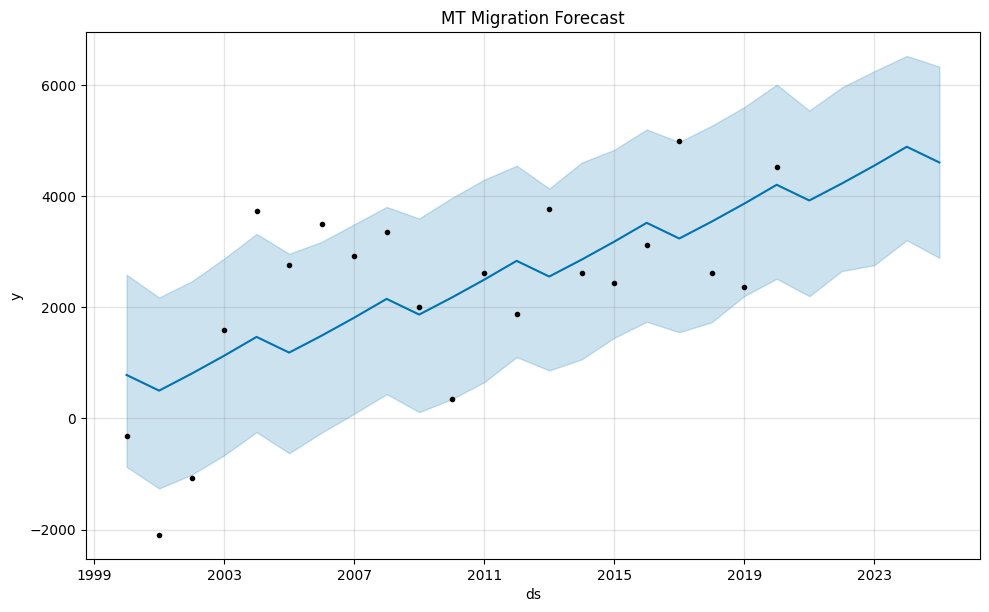

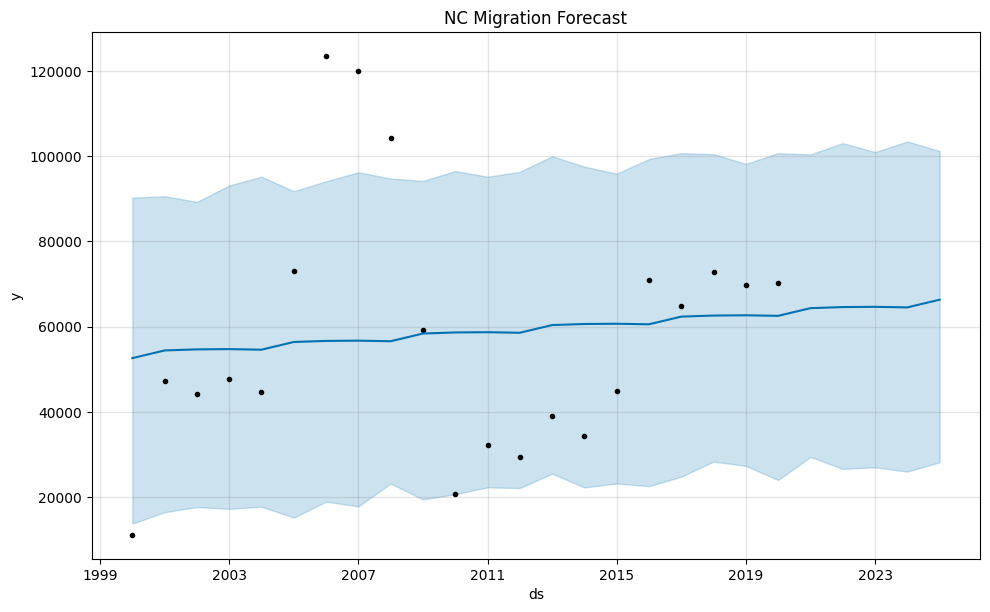

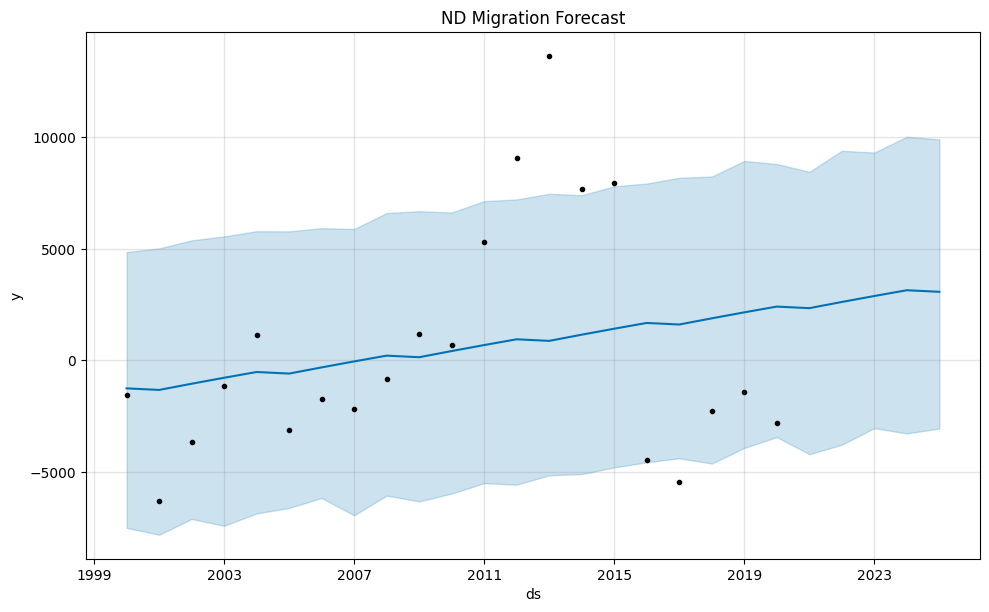

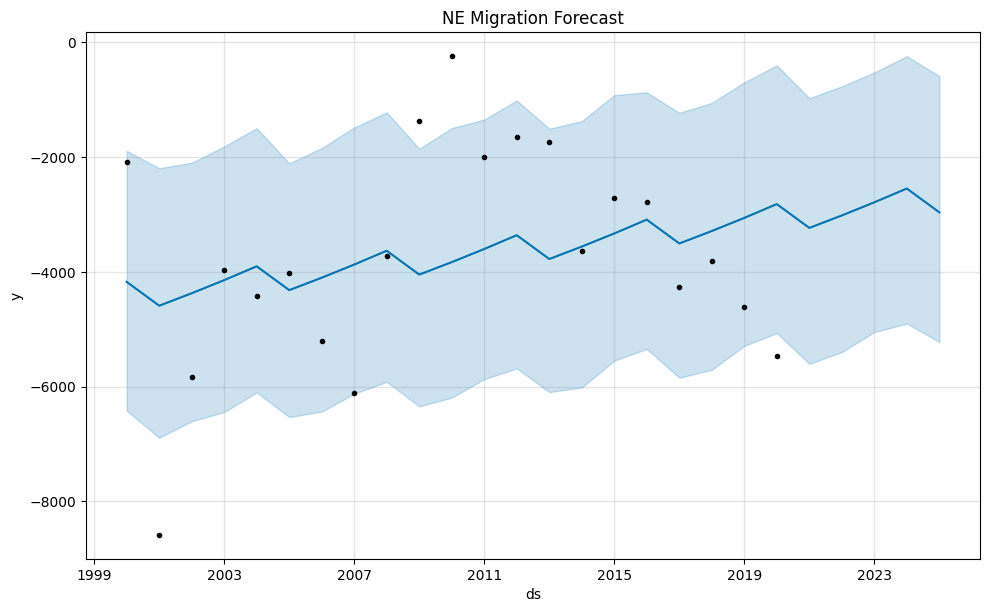

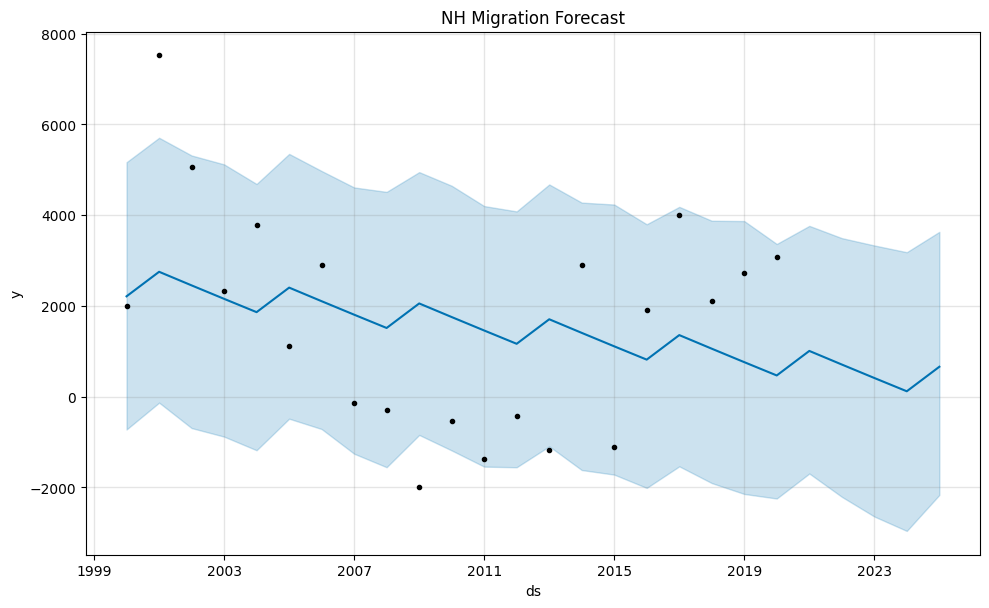

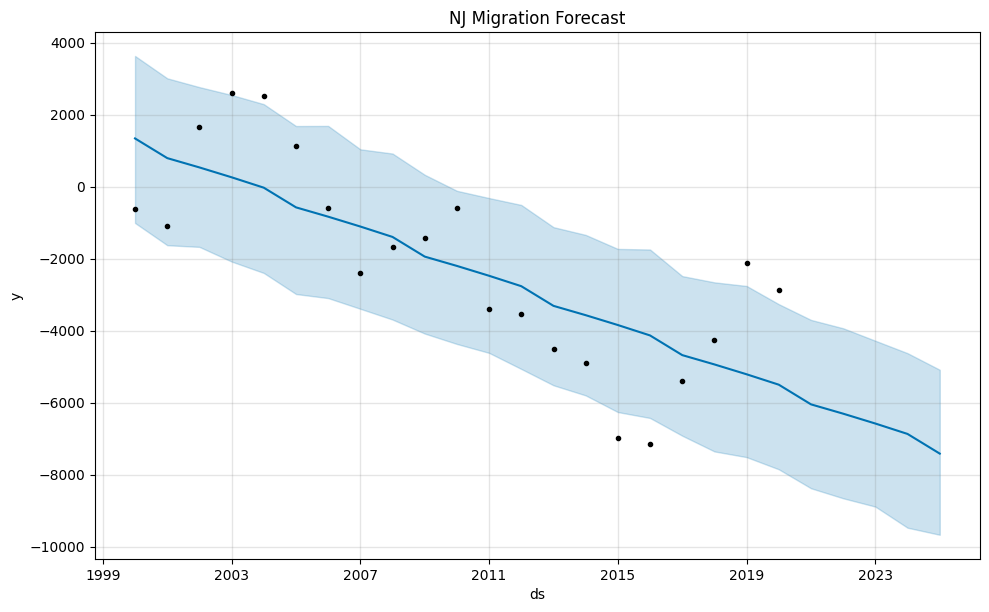

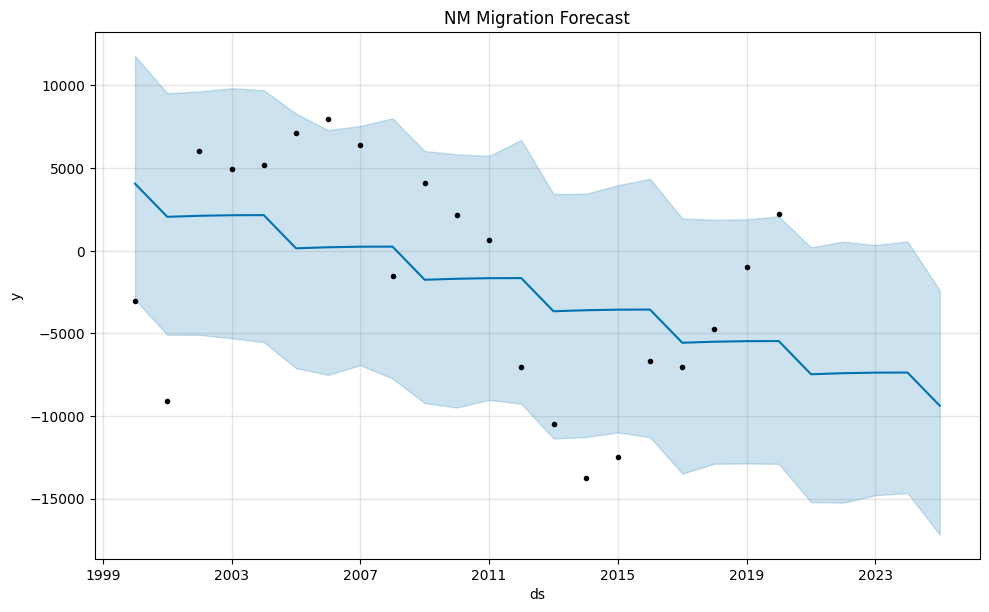

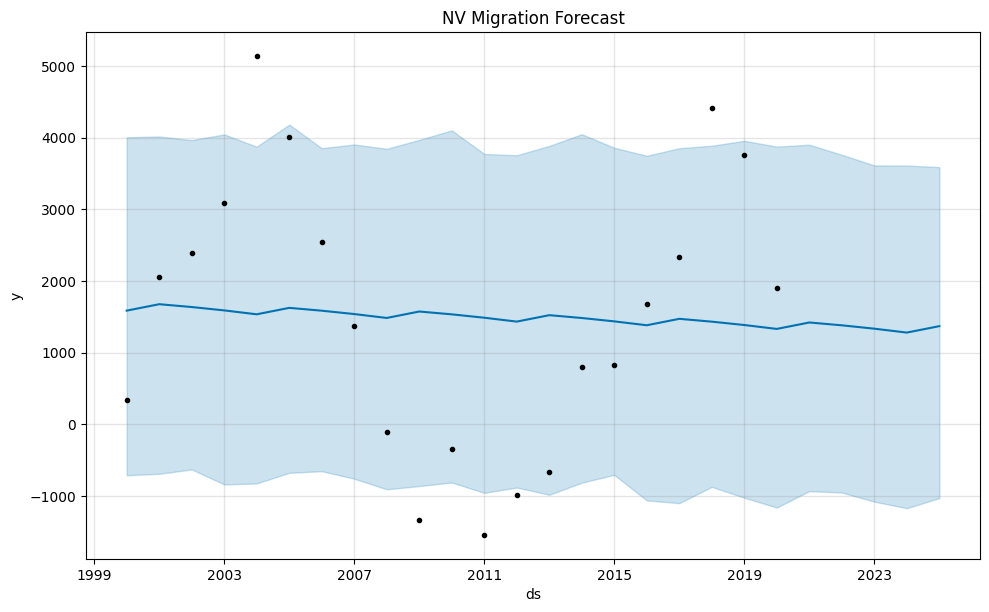

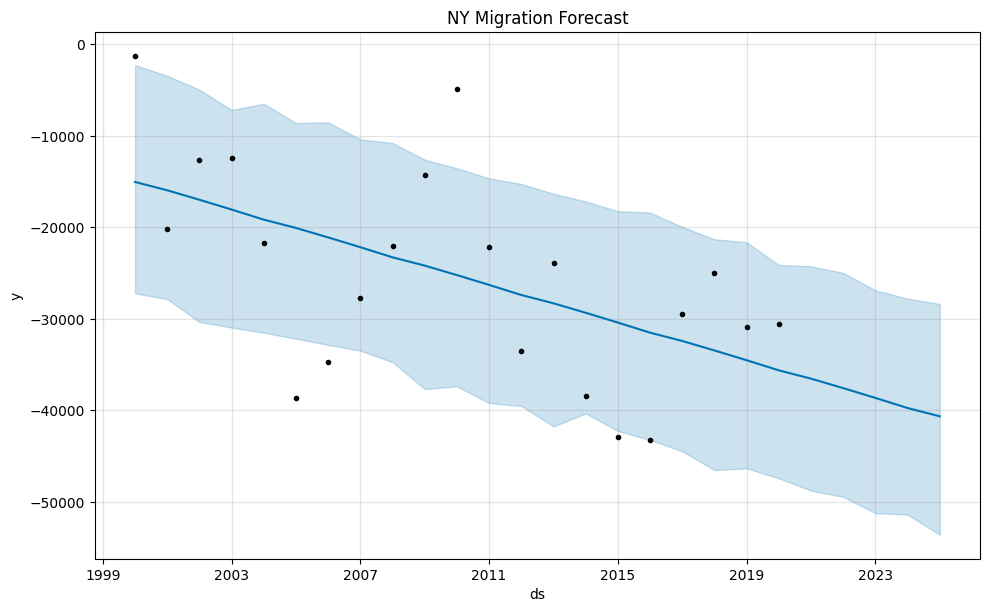

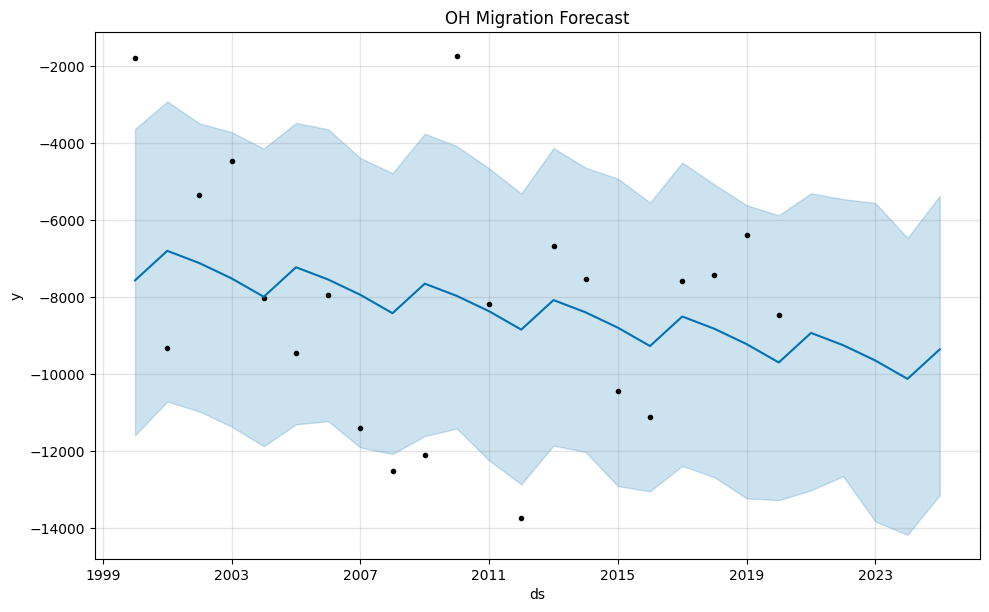

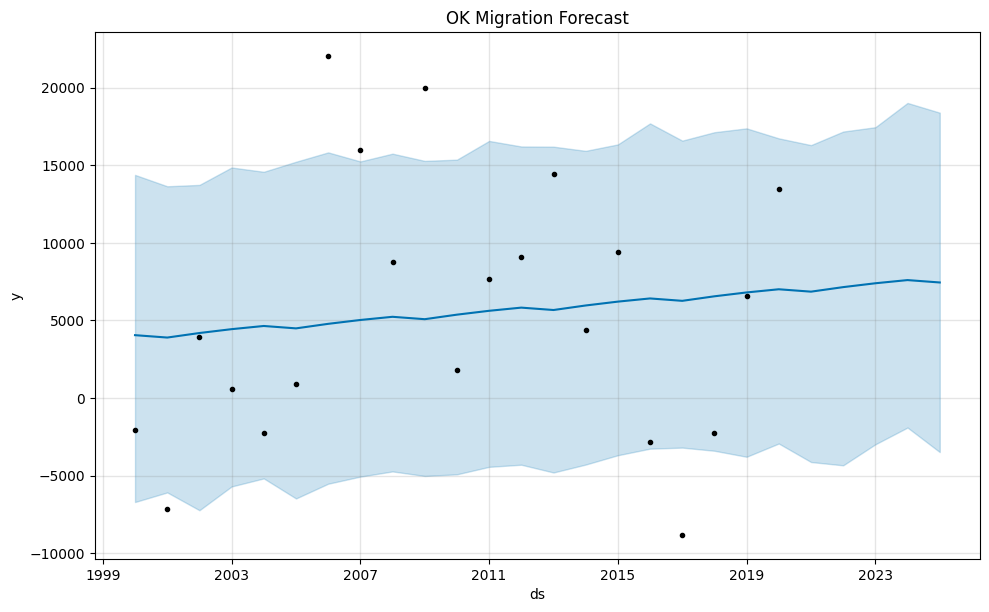

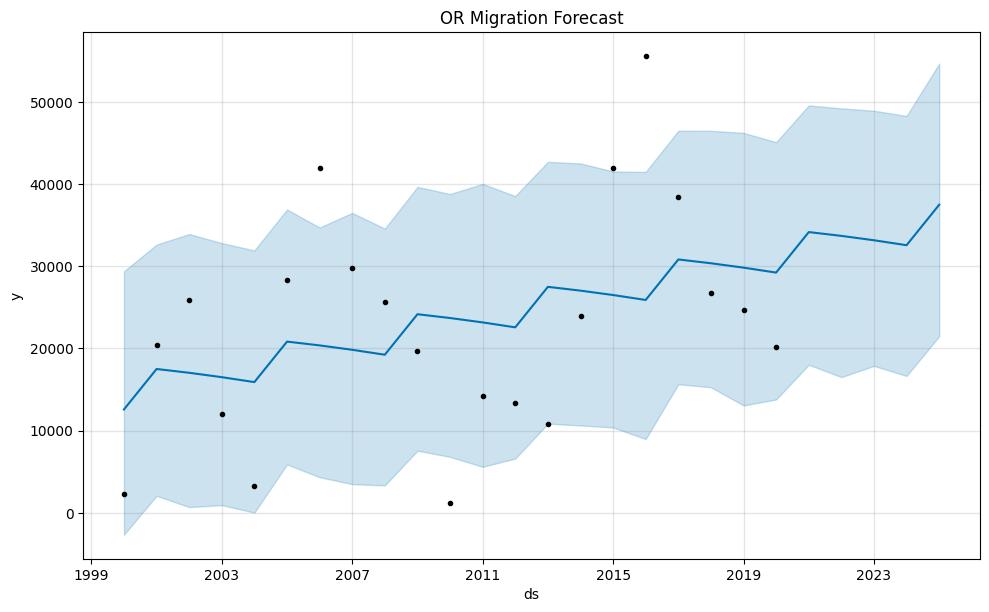

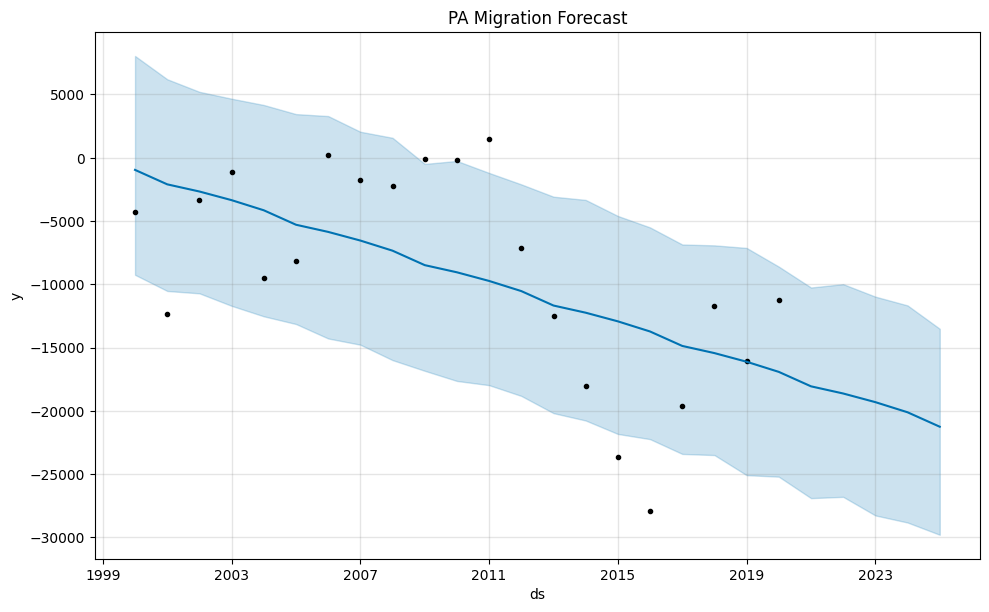

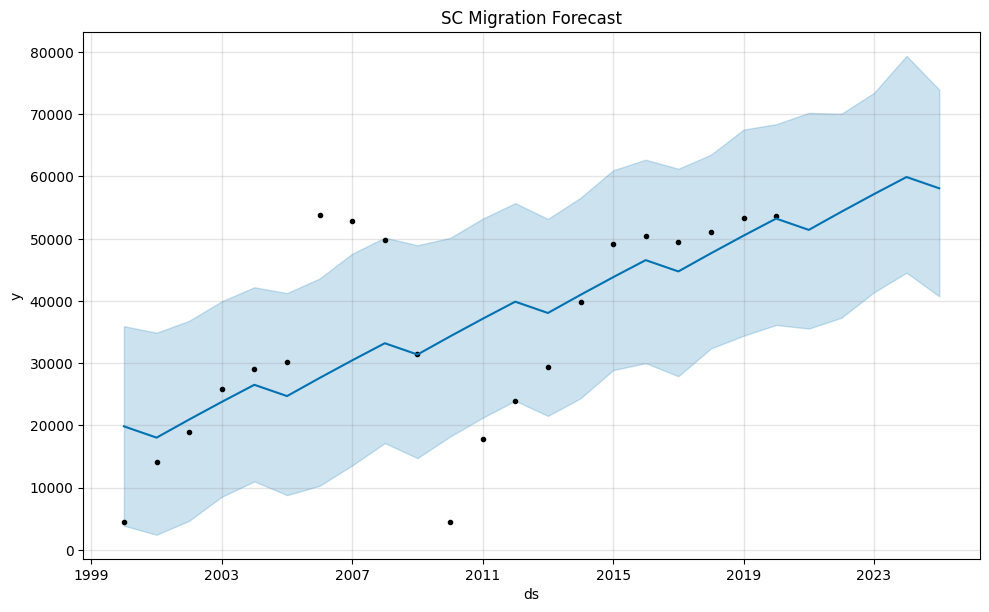

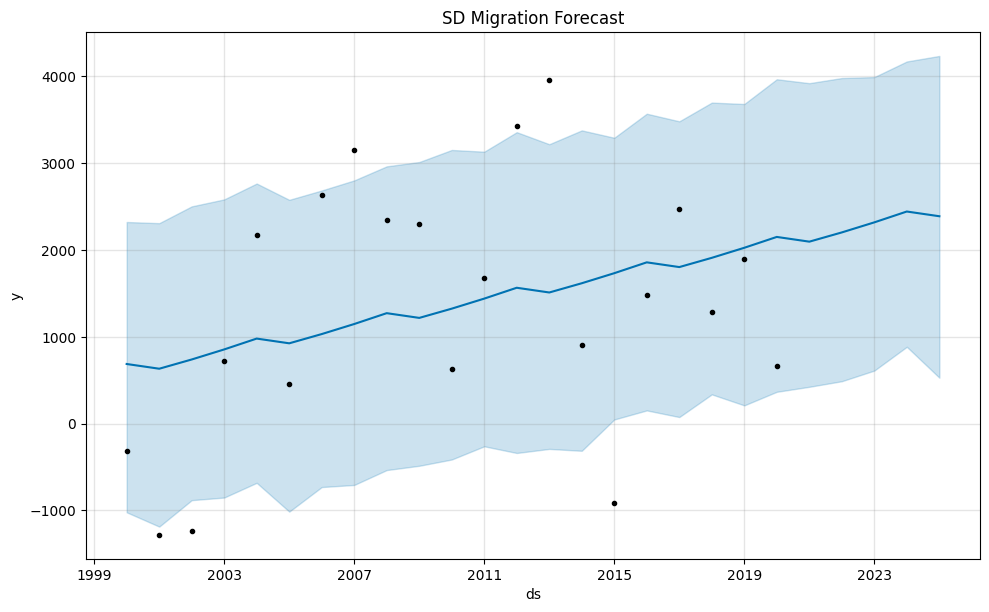

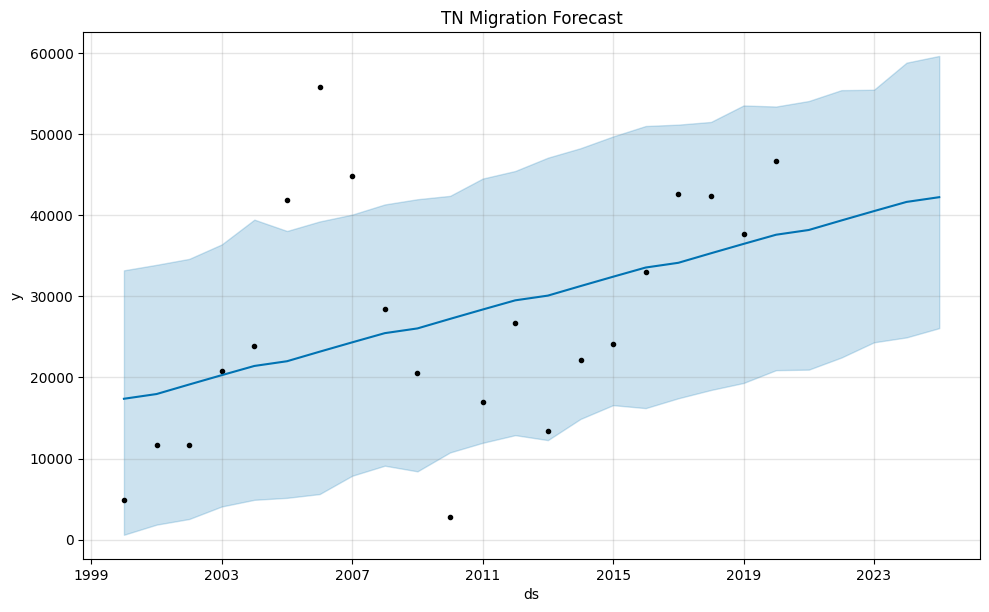

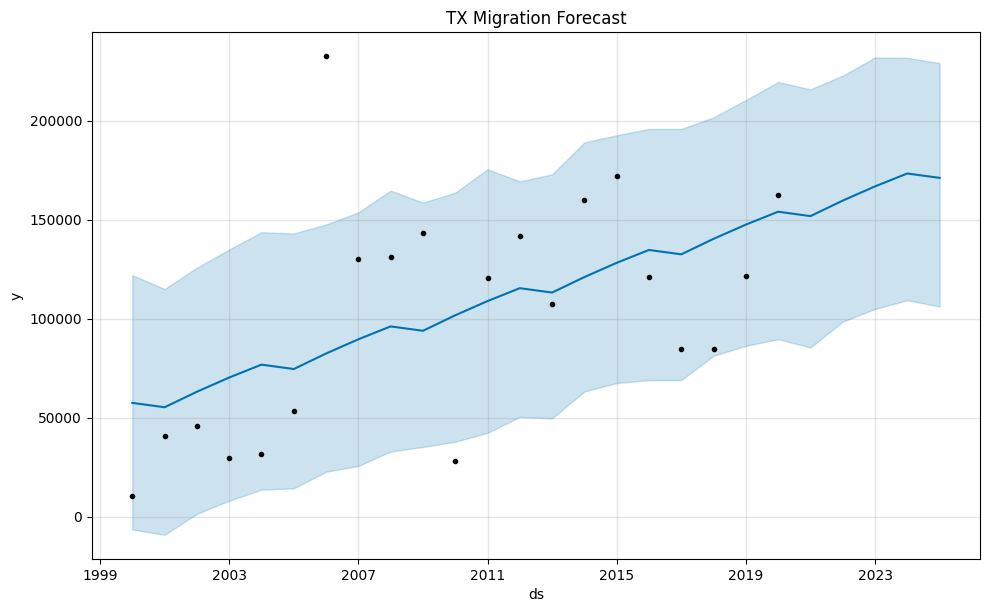

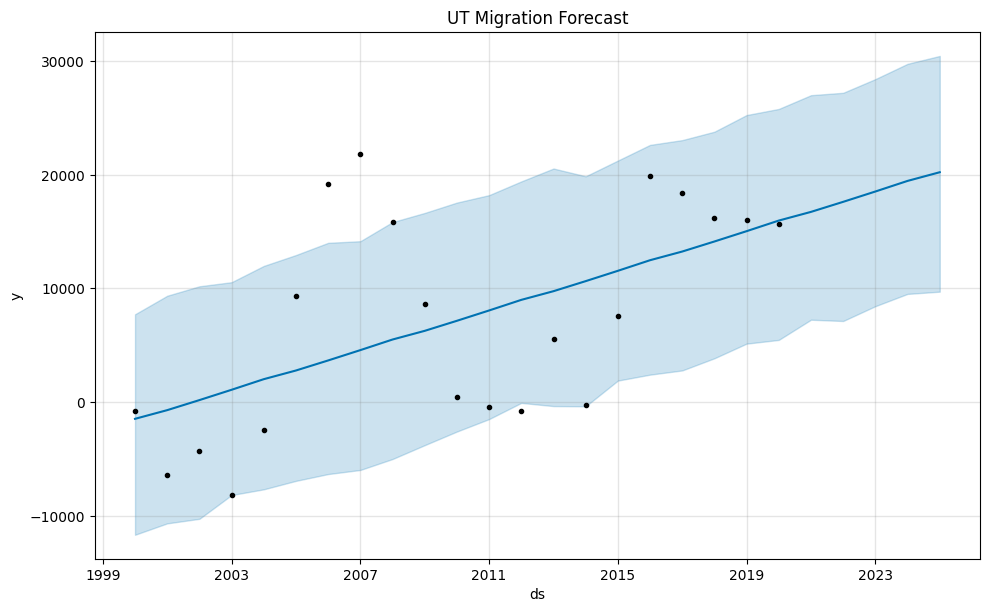

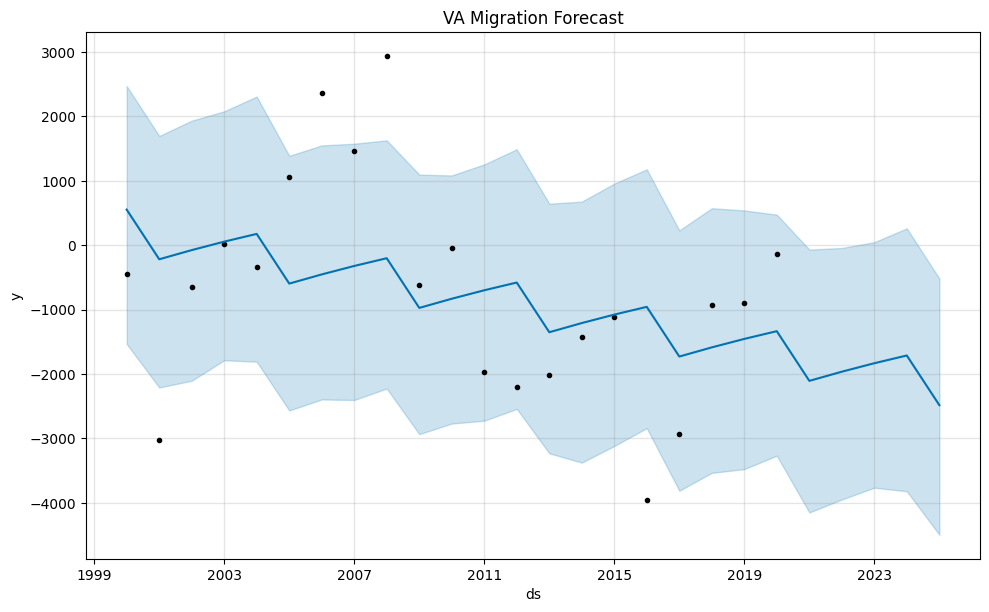

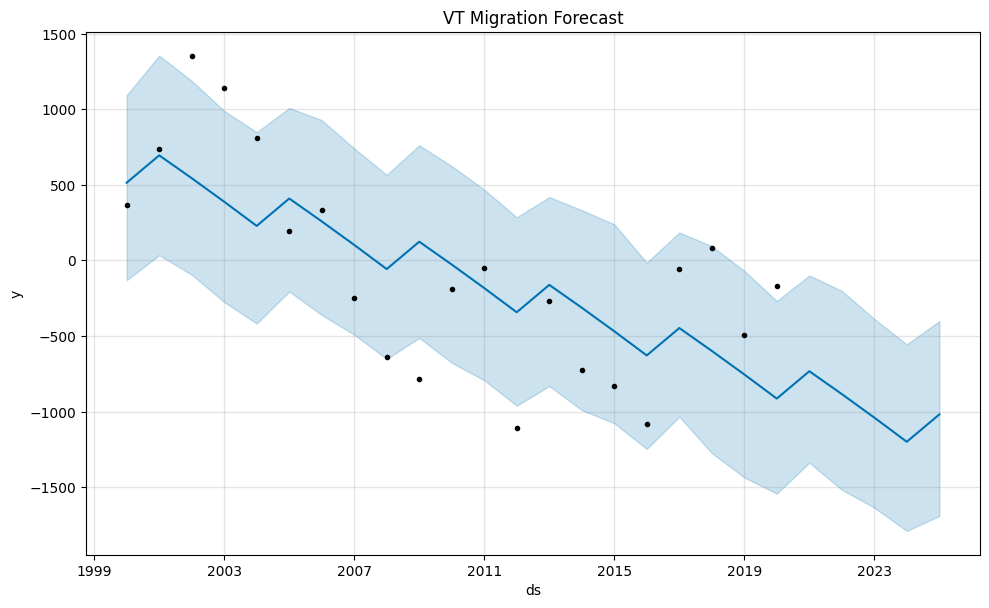

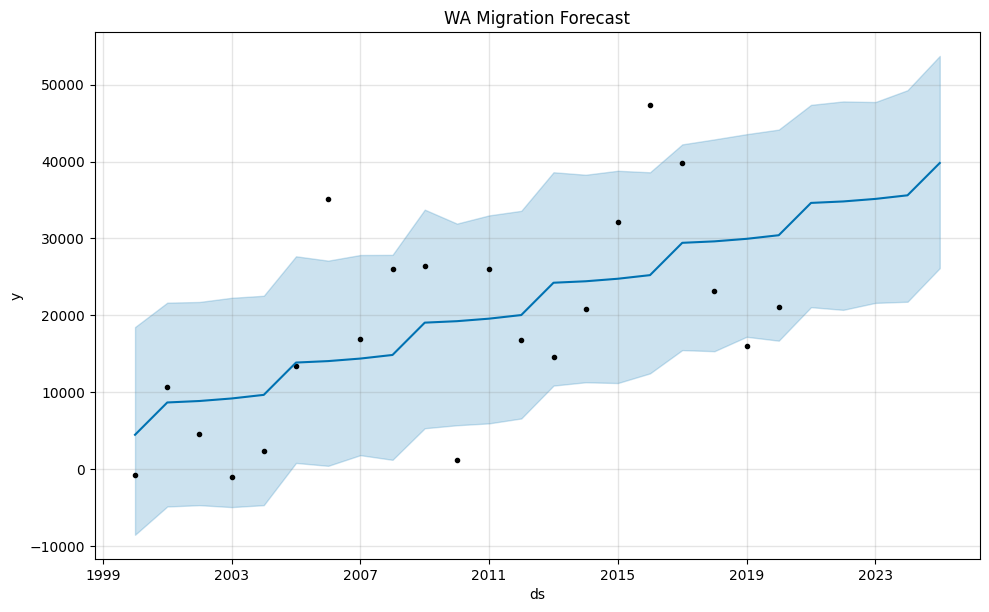

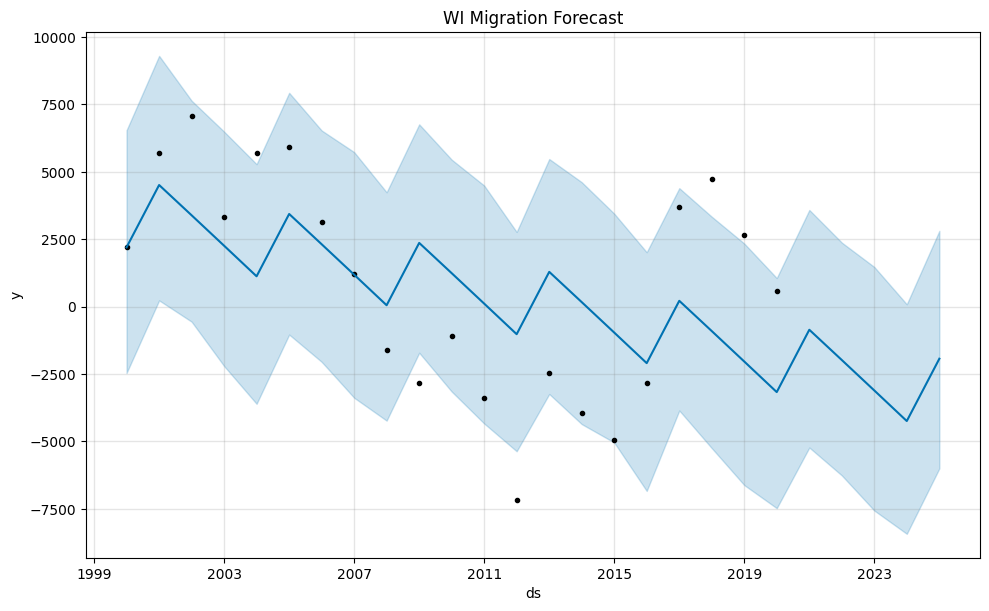

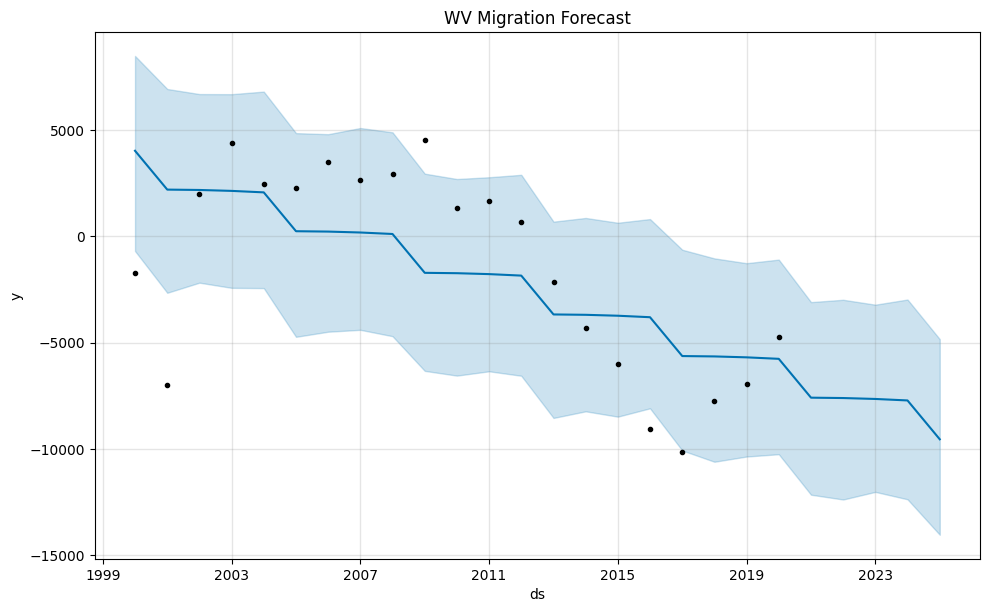

In [97]:

def run_prophet(df, state):

    df['ds'] = pd.to_datetime(df['Year'], format='%Y')
    df = df[['ds', 'Net Domestic Migration']]

    # Rename the 'Net Domestic Migration' column to 'y'
    df.rename(columns={'Net Domestic Migration': 'y'}, inplace=True)

    # Create the model
    model = Prophet()

    # Fit the model
    model.fit(df)

    # Create a future DataFrame for predictions
    future = model.make_future_dataframe(periods=5, freq='YS')

    # Make predictions
    forecast = model.predict(future)

     # Plot the forecast with a title
    fig = model.plot(forecast)
    plt.title(f'{state} Migration Forecast')

# Run Prophet for each state with for loop
for state, state_df in state_dfs.items():
    run_prophet(state_df, state)